In [1]:
import rebound
import reboundx
import numpy as np
from rebound import InterruptiblePool
%matplotlib inline
import matplotlib.pyplot as plt

def getstr(dt):
    return "{:.0e}".format(dt)
def i15(par):
    run, mp, tau_e, e0, tmax, Nout, dt, damping = par
    
    sim = rebound.Simulation()
    sim.integrator = "ias15"
    sim.ri_ias15.epsilon = 0.
    sim.dt = dt
    sim.add(m=1.)
    
    sim.add(m=mp,a=1.,e=e0)
    sim.add(m=mp,a=2.,e=0.2)
    sim.move_to_com() # Moves to the center of momentum frame  
    
    if damping is True:
        rebx = reboundx.Extras(sim)
        rebx.add_modify_orbits_direct()
    
        tau_es = rebx.modify_orbits_direct.tau_e
        tau_es[1] = tau_e    
    
    times = np.logspace(0,np.log10(tmax),Nout)
    ts, e1, e2, r1, r2, E = np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times))
    for i,time in enumerate(times):
        sim.integrate(time, exact_finish_time=1)
        ts[i] = sim.t
        o = sim.calculate_orbits()
        r1[i] = o[0].r
        r2[i] = o[1].r
        e1[i] = o[0].e
        e2[i] = o[1].e
        E[i] = sim.calculate_energy()

    prede = [e0*np.exp(t/tau_e) for t in ts]
    return [times, r1, r2, e1, e2, E, prede]

In [2]:
def ploti15toi15(ax1,ax2,ax3, run=1, Nout=100, tmax=1e4, mp=1e-3, tau_e=-1e3, e0=0.1, dt=1.e-2, damping=True, color='r'):
    alpha = 0.2
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    
    params = [(run, mp, tau_e, e0, tmax, Nout, dt, damping)]
    pool = InterruptiblePool()
    res1 = pool.map(i15, params)
    params2 = [(1, mp, tau_e, e0, tmax, Nout, dt/10., damping)]
    res2 = pool.map(i15, params2)

    res1 = res1[0]
    res2 = res2[0]
    
    times = res1[0]
    r1err = np.fabs(np.array(res1[1])-np.array(res2[1]))/np.array(res2[1])
    r2err = np.fabs(np.array(res1[2])-np.array(res2[2]))/np.array(res2[2])
    e1err = np.fabs(np.array(res1[3])-np.array(res2[3]))/np.array(res2[3])
    e2err = np.fabs(np.array(res1[4])-np.array(res2[4]))/np.array(res2[4])
    Eerr = np.fabs(np.array(res1[5])-np.array(res2[5]))/np.fabs(np.array(res2[5]))
     
    ax1.plot(times, r1err, color=color, alpha=alpha)
    #ax1.plot(times, r2err, color=color, linestyle='--', alpha=alpha)
    ax2.plot(times, e1err, color=color, alpha=alpha)
    #ax2.plot(times, e2err, color=color, linestyle='--', alpha=alpha)
    ax3.plot(times, Eerr, color=color, alpha=alpha)
   
    ax1.set_xlabel(r'Time', fontsize=24)
    ax2.set_xlabel(r'Time', fontsize=24)
    ax3.set_xlabel(r'Time', fontsize=24)
    ax1.set_ylabel(r'Relative orb. radius err', fontsize=24)
    ax2.set_ylabel(r'Relative ecc. error', fontsize=24)
    ax3.set_ylabel(r'Relative E error', fontsize=24)
    #ax.tick_params(labelsize=12)

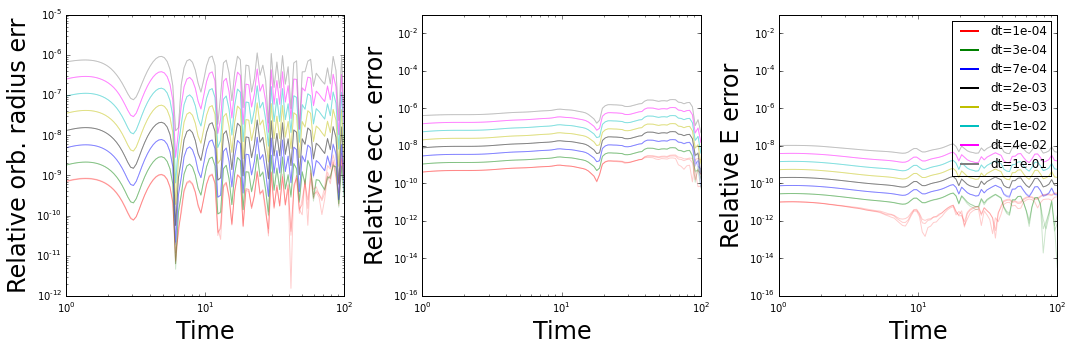

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, figsize=(15,5))
Ndts = 4
dts = np.logspace(-Ndts, -1, 2*Ndts)
colors = ['r', 'g', 'b', 'k', 'y', 'c', 'fuchsia', 'gray']
Nruns=3
e0 = 1.e-1
for run in range(Nruns):
    np.random.seed(run)
    e0 = e0 + 1.e-3*e0*np.random.rand()
    for i, dt in enumerate(dts): 
        ploti15toi15(ax1,ax2,ax3,run,mp=1e-3, e0=e0, tau_e=-1000., tmax=1e2,dt=dt, damping=True, color=colors[i])

labels = [plt.Line2D((0,1),(0,0), color=c, linestyle='-', linewidth=2) for c in colors]
dtstrs = [getstr(dt) for dt in dts]
ax3.legend(labels, ['dt='+dtstr for dtstr in dtstrs])
ax2.set_ylim([1.e-16, 1.e-1])
ax3.set_ylim([1.e-16, 1.e-1])
plt.tight_layout()